Epoch 1/100 | Train Loss: 0.0163 | Val Loss: 0.0072
Epoch 2/100 | Train Loss: 0.0076 | Val Loss: 0.0059
Epoch 3/100 | Train Loss: 0.0070 | Val Loss: 0.0061
Epoch 4/100 | Train Loss: 0.0068 | Val Loss: 0.0064
Epoch 5/100 | Train Loss: 0.0067 | Val Loss: 0.0058
Epoch 6/100 | Train Loss: 0.0065 | Val Loss: 0.0058
Epoch 7/100 | Train Loss: 0.0064 | Val Loss: 0.0058
Epoch 8/100 | Train Loss: 0.0064 | Val Loss: 0.0060
Epoch 9/100 | Train Loss: 0.0062 | Val Loss: 0.0057
Epoch 10/100 | Train Loss: 0.0062 | Val Loss: 0.0060
Epoch 11/100 | Train Loss: 0.0062 | Val Loss: 0.0060
Epoch 12/100 | Train Loss: 0.0061 | Val Loss: 0.0057
Epoch 13/100 | Train Loss: 0.0061 | Val Loss: 0.0058
Early stopping at epoch 14


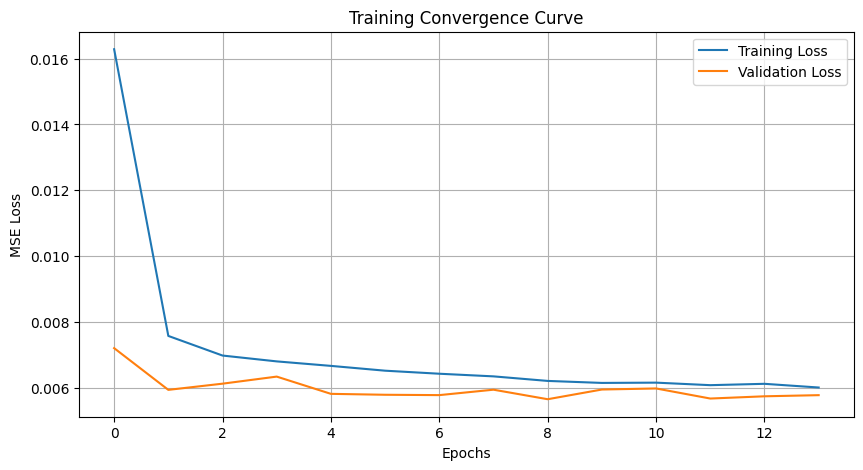

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# ==================== 数据预处理 ====================
class PollutionDataset(Dataset):
    """时间序列数据集"""
    def __init__(self, data, seq_length=24):
        self.seq_length = seq_length
        self.data = torch.FloatTensor(data)
        
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length, :-1]  # 取前n个时间步的特征
        y = self.data[idx+self.seq_length, -1]       # 取第n+1时间步的目标值
        return x, y

def preprocess_data(filepath):
    # 加载原始数据
    df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
    
    # 处理非数值列
    if 'wnd_dir' in df.columns:
        df['wnd_dir'] = df['wnd_dir'].astype('category').cat.codes
    
    # 重采样并填充缺失值
    df = df.resample('h').mean(numeric_only=True)
    df = df.interpolate(method='linear')
    
    # 异常值处理
    if 'pollution' in df.columns:
        df['pollution'] = np.where(df['pollution']>300, 300, df['pollution'])
    
    # 构造时间特征
    df['hour'] = df.index.hour
    df['day_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    
    # 生成滞后特征
    for lag in [1,2,3]:
        df[f'pollution_lag{lag}'] = df['pollution'].shift(lag)
    
    df = df.dropna()
    
    # 特征选择
    features = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 
                'snow', 'rain', 'hour', 'day_cos', 'pollution_lag1', 
                'pollution_lag2', 'pollution_lag3']
    target = 'pollution'
    
    # 数据归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[features + [target]])
    
    return scaled_data, scaler, df

# ==================== LSTM模型 ====================
class PollutionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])  # 取最后一个时间步
        return self.linear(lstm_out)

# ==================== 训练函数 ====================
def train_model(model, train_loader, val_loader, n_epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_loss = float('inf')
    
    # 添加损失记录
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val).squeeze()
                val_loss += criterion(outputs, y_val).item() * X_val.size(0)
        
        # 计算平均损失
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        
        # 记录损失
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # 早停机制
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_lstm_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= 5:
            print(f'Early stopping at epoch {epoch+1}')
            break
        
        print(f'Epoch {epoch+1}/{n_epochs} | '
              f'Train Loss: {train_loss:.4f} | '
              f'Val Loss: {val_loss:.4f}')
         # 绘制训练过程曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training Convergence Curve')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("1.png")
    plt.show()

    
    # 加载最佳模型
    model.load_state_dict(torch.load('best_lstm_model.pth'))
    return model

# ==================== 主程序 ====================
if __name__ == "__main__":
    # 数据预处理
    scaled_data, scaler, raw_df = preprocess_data('LSTM-Multivariate_pollution.csv')
    
    # 创建数据集
    dataset = PollutionDataset(scaled_data, seq_length=24)
    
    # 数据划分
    train_size = int(len(dataset)*0.8)
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    # 创建DataLoader
    train_loader = DataLoader(train_dataset, batch_size=72, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=72, shuffle=False)
    
    # 初始化模型
    input_size = scaled_data.shape[1] - 1  # 减去目标列
    model = PollutionLSTM(input_size=input_size)
    
    # 训练模型
    trained_model = train_model(model, train_loader, test_loader, n_epochs=100)
    
    # 模型评估
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trained_model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test = X_test.to(device)
            outputs = trained_model(X_test).squeeze().cpu().numpy()
            y_pred.extend(outputs)
            y_true.extend(y_test.numpy())
    

In [17]:
# 计算指标(归一化)
print(f'MAE: {mean_absolute_error(y_true, y_pred):.2f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}')
print(f'R² Score: {r2_score(y_true, y_pred):.2f}')
# 反归一化
def inverse_scale(data, scaler, feature_num):
    dummy = np.zeros((len(data), feature_num))
    dummy[:, -1] = data
    return scaler.inverse_transform(dummy)[:, -1]

y_true = inverse_scale(y_true, scaler, scaled_data.shape[1])
y_pred = inverse_scale(y_pred, scaler, scaled_data.shape[1])

# 保存完整模型
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'scaler': scaler,
    'input_size': input_size
}, 'pollution_forecaster.pth')

MAE: 0.04
RMSE: 0.08
R² Score: 0.92


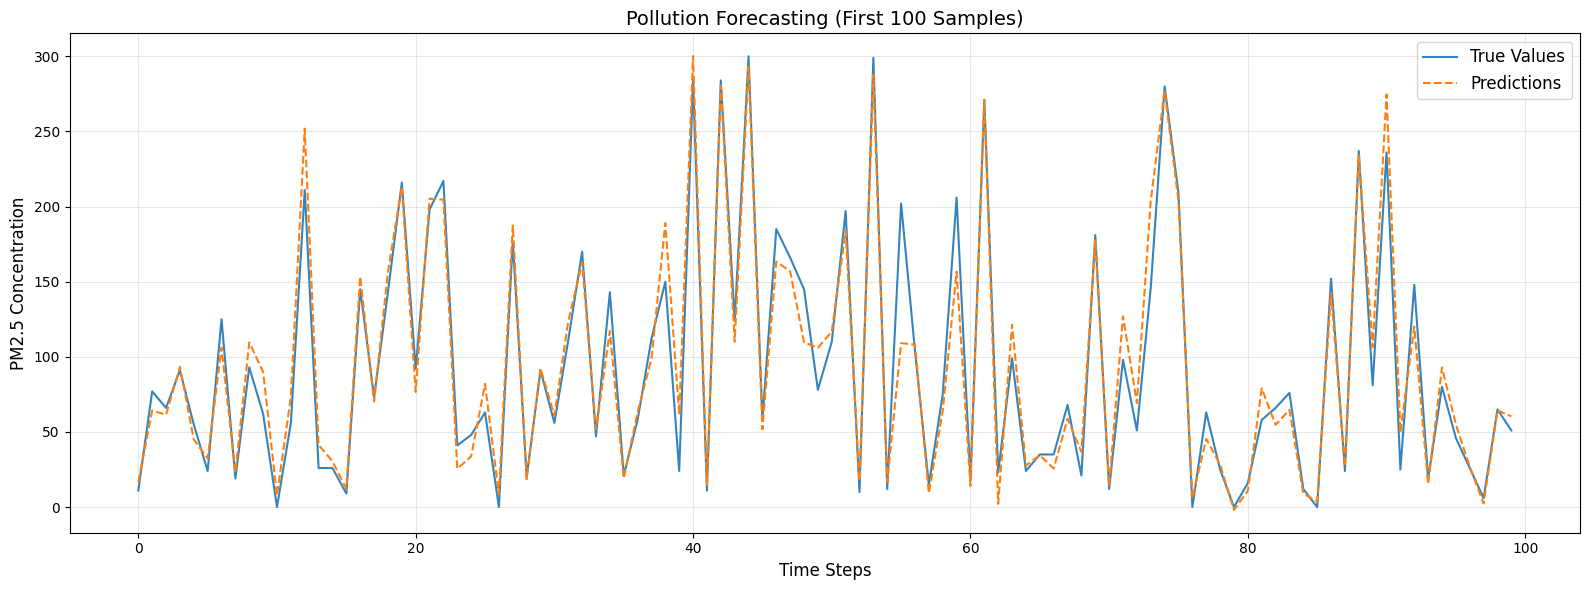

In [18]:
vis_samples = 100

plt.figure(figsize=(16, 6))
plt.plot(y_true[:vis_samples], label='True Values', linewidth=1.5, alpha=0.9)
plt.plot(y_pred[:vis_samples], label='Predictions', linestyle='--', linewidth=1.5)


plt.title(f'Pollution Forecasting (First {vis_samples} Samples)', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('PM2.5 Concentration', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.savefig("2.png")
plt.show()

